# Segment 1: Introduction to "The Tensor View"

## 1. First Impressions: The World as Tensors
Before we can interpret a network, we must see what the network sees. To a CNN, an image is not a photograph; it is a 3-dimensional volume of intensity values. The first dimension is usually the "channels" (Color), followed by spatial dimensions (Height and Width).

In this segment, we will strip away the "image" metaphor and look at the raw data structures (Tensors) that the model actually processes.

Original Image Size: (1546, 1213)
Tensor Shape (C, H, W): torch.Size([3, 224, 224])


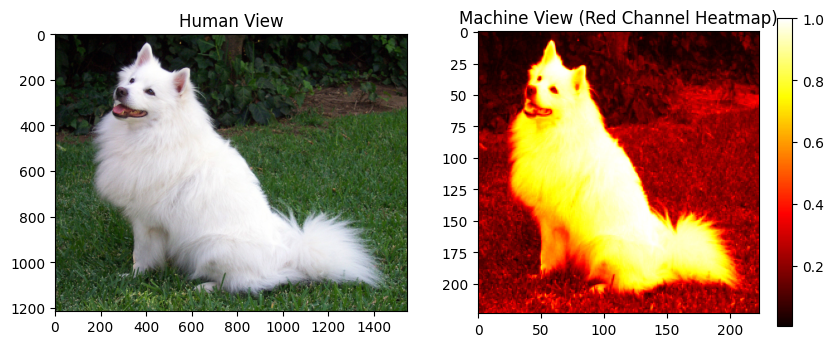

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# 1. Load a sample image (Robust method)
# We use a stable image URL from the PyTorch repository to avoid download errors
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# 2. Transform to Tensor (The Native Language of CNNs)
# Note: PyTorch uses (Channels, Height, Width) format
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img_tensor = preprocess(img)

# 3. Visualize the "Volume"
print(f"Original Image Size: {img.size}")
print(f"Tensor Shape (C, H, W): {img_tensor.shape}")

# Plotting the Red channel specifically to show it's just a grid of numbers
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.imshow(img); plt.title("Human View")
# We grab the first channel (0 = Red) to visualize the heatmap
plt.subplot(1, 2, 2); plt.imshow(img_tensor[0], cmap='hot'); plt.title("Machine View (Red Channel Heatmap)")
plt.colorbar()
plt.show()

## 2. Convolutions: The Local Pattern Detectors
How does the network make sense of this volume? It uses **Filters** (kernels). A filter is a small window (e.g., 3x3) that slides over the image. If the image patch matches the filter's pattern, the output is high. If it doesn't, the output is low.

Let's manually create a "Vertical Edge Detector" filter and slide it over our image to see this activation map in action. This is exactly what early layers in InceptionV1 (like `conv2d0`) do automatically.

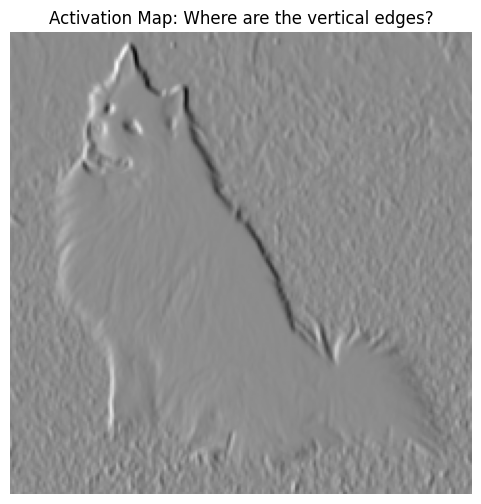

In [5]:
import torch.nn.functional as F

# 1. Define a manual "Vertical Edge" filter (Sobel-like)
# Pattern: Left side is negative, Right side is positive.
# This will "excite" when it sees a vertical line (transition from dark to light).
filter_weights = torch.tensor([[-1., 0., 1.],
                               [-1., 0., 1.],
                               [-1., 0., 1.]]).view(1, 1, 3, 3)

# 2. Apply the filter to the image using Functional Convolution
# We apply it to just the Red channel for simplicity (unsqueeze adds batch dim)
red_channel = img_tensor[0].unsqueeze(0).unsqueeze(0)
activation_map = F.conv2d(red_channel, filter_weights)

# 3. Visualize: The "Feature Map"
# Notice how vertical edges light up (bright) and flat areas are dark (zero).
plt.figure(figsize=(6, 6))
plt.imshow(activation_map.squeeze(), cmap='gray')
plt.title("Activation Map: Where are the vertical edges?")
plt.axis('off')
plt.show()

## 3. The Hierarchy: From Details to Concepts
Real networks stack these operations. As we go deeper, two things happen:
1.  **Spatial Resolution Drops:** We lose "where" things are (pixels).
2.  **Channel Depth Increases:** We gain "what" things are (concepts).

Let's inspect the shapes of the tensors inside **InceptionV1** (GoogLeNet) to see how the grid shrinks from 224x224 down to 7x7.

In [8]:
from torchvision import models

# 1. Load a standard pretrained model (GoogLeNet/InceptionV1)
# This is the standard PyTorch version of the model often used in Lucent
model = models.googlenet(weights='DEFAULT')

# 2. Hook the layers to spy on the tensor shapes
# We want to see how the 'box' changes size at different depths.
shapes = {}
def get_shape(name):
    def hook(model, input, output):
        shapes[name] = output.shape
    return hook

# Attach hooks to specific layers (Early, Middle, Late)
# Note: These names match the standard Torchvision implementation
model.inception3a.register_forward_hook(get_shape("inception3a (Early)"))
model.inception4a.register_forward_hook(get_shape("inception4a (Middle)"))
model.inception5b.register_forward_hook(get_shape("inception5b (Late)"))

# 3. Pass the image through
# The model expects a batch, so we add a dimension: (1, 3, 224, 224)
_ = model(img_tensor.unsqueeze(0))

# 4. Print the "Funnel"
print(f"{'Layer Name':<25} | {'Tensor Shape (Batch, C, H, W)':<30} | {'Interpretation'}")
print("-" * 85)
print(f"{'Input Image':<25} | {str(tuple(img_tensor.unsqueeze(0).shape)):<30} | Raw Pixels")
for name, shape in shapes.items():
    print(f"{name:<25} | {str(tuple(shape)):<30} | Channels up, Spatial size down")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:01<00:00, 44.7MB/s]


Layer Name                | Tensor Shape (Batch, C, H, W)  | Interpretation
-------------------------------------------------------------------------------------
Input Image               | (1, 3, 224, 224)               | Raw Pixels
inception3a (Early)       | (1, 256, 28, 28)               | Channels up, Spatial size down
inception4a (Middle)      | (1, 512, 14, 14)               | Channels up, Spatial size down
inception5b (Late)        | (1, 1024, 7, 7)                | Channels up, Spatial size down


### Reference: The Life of a Tensor in InceptionV1
Below is a summary of how the input image is transformed as it flows through the network. Notice the trade-off: **Spatial dimensions ($H \times W$) decrease** while **Depth (Channels) increases**.

| Stage | Operation | Input Shape $(C \times H \times W)$ | Output Shape $(C \times H \times W)$ | What happens? |
| :--- | :--- | :--- | :--- | :--- |
| **Input** | Raw Image | $3 \times 224 \times 224$ | $3 \times 224 \times 224$ | The starting RGB image. |
| **Stem** | Conv1 + MaxPool | $3 \times 224 \times 224$ | $64 \times 56 \times 56$ | **Rapid Downsampling.** The image is crushed to 1/4th its size to save computation. |
| **Stem** | Conv2 + MaxPool | $64 \times 56 \times 56$ | $192 \times 28 \times 28$ | **Feature Extraction.** The grid is now 28x28. Simple textures are detected. |
| **Block 3** | Inception 3a & 3b | $192 \times 28 \times 28$ | $480 \times 28 \times 28$ | **Texture Analysis.** Depth increases massively as many filters run in parallel. |
| **Transition** | MaxPool (3x3) | $480 \times 28 \times 28$ | $480 \times 14 \times 14$ | **Spatial Reduction.** The grid shrinks to 14x14. |
| **Block 4** | Inception 4a - 4e | $480 \times 14 \times 14$ | $832 \times 14 \times 14$ | **Object Parts.** The "sweet spot" for Lucent. Complex shapes (eyes, wheels) emerge. |
| **Transition** | MaxPool (3x3) | $832 \times 14 \times 14$ | $832 \times 7 \times 7$ | **Spatial Reduction.** The grid is now tiny (7x7). |
| **Block 5** | Inception 5a & 5b | $832 \times 7 \times 7$ | $1024 \times 7 \times 7$ | **Whole Objects.** The network sees global concepts (entire dogs, cars). |
| **Classifier**| Global Avg Pool | $1024 \times 7 \times 7$ | $1024 \times 1 \times 1$ | **Spatial Collapse.** We stop caring "where" things are, only "what" they are. |
| **Output** | Linear / Softmax | $1024 \times 1 \times 1$ | $1000$ | **Prediction.** Scores for the 1000 ImageNet classes. |

---

#### **Key Operations Legend**
* **Convolution (Conv):** Slides a filter over the input to detect features.
* **MaxPool:** Keeps only the highest value in a window (e.g., 2x2). This shrinks the image and makes the network translation-invariant (it recognizes a cat whether it's in the top-left or bottom-right).
* **Inception Module:** Runs multiple convolutions (1x1, 3x3, 5x5) in parallel and stacks their results. This allows the layer to capture both fine details and broader patterns simultaneously.
* **Global Average Pool:** Takes the average of each channel's entire grid. This converts the 3D feature maps into a 1D vector for final classification.